# Context and Content based Music Recommender System using Embedding

In [ ]:
pip install gensim==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.9 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## Importing required modules and data

### Installing required modeules

In [ ]:
%pip install numpy
%pip install pandas
%pip install sklearn
%pip install matplotlib
%pip install progressBar
%pip install networkx
%pip install tqdm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=5eb6343417d66dd5dc4804812641aea14c48c1b1341125e254d17ca0009d698b
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for progressBar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=05cb73bbe8263986fcf7ed9b49da1285526e8b8c698d1870610726d16bf5ccc6
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tqdm import notebook as notebook
from sklearn.manifold import TSNE
import random
import pickle
import gensim 
import logging
import math

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Importing data


In [ ]:
pre_processed = pd.read_csv('/content/drive/MyDrive/pre_processed_nowplaying.csv')
print(pre_processed.shape)

(3624649, 21)


In [ ]:
# Dropping rows where user_id, tracl_id and created_at have same values.
# Around 2,00,000 rows are removed after this.
pre_processed = pre_processed.drop_duplicates(subset=['user_id','track_id','created_at'])
print(pre_processed.shape)

(3457626, 21)


## Processing dataset

In [ ]:
def convert_col(data):
  #Converting user_id to string because some part of the code requires all arguments to be string
  data = data.astype({"user_id": str})

  #Appending a prefix to columns. This is done to identify the type of node in late part .
  data['user_id'] = 'user' + data['user_id'].astype(str)
  data['track_id'] = 'track' + data['track_id'].astype(str)
  data['artist_id'] = 'artist' + data['artist_id'].astype(str)
  data['lang'] = 'lang' + data['lang'].astype(str)
  return data

In [ ]:
#Currently only a subset of data is used for building network and training the model
# pre_processed = pre_processed.head(10000)
pre_processed = convert_col(pre_processed)



In [ ]:
print(pre_processed.head())


   Unnamed: 0  sentiment_score        user_id  \
0           0              2.4  user104415394   
2           2              2.4  user240771401   
3           3              2.4  user252330820   
4           4              2.4   user29235188   
7           7              2.4  user954234692   

                                track_id           created_at  \
0  track9175ac1532ee7dbe97602866efabac58  2014-05-20 07:24:40   
2  trackc2da30eb3450e8a3e5bfa16e8fa527da  2014-10-12 22:46:57   
3  track8f2ac86abb8bd48273c8fc95b632e347  2014-02-13 16:18:51   
4  track45bbd6d7cd65dc77596af8c5c0b89a70  2014-05-15 20:38:46   
7  track6d45097acaaf6ed5ee55041f53249fa0  2014-10-22 18:33:52   

   instrumentalness  liveness  speechiness  danceability  valence  ...  \
0           0.00131    0.2990       0.0225         0.624    0.319  ...   
2           0.00000    0.3060       0.0309         0.583    0.219  ...   
3           0.00000    0.1980       0.1690         0.461    0.502  ...   
4           0.0000

In [ ]:
# pre_processed_head = pre_processed.head(15000)
# pre_processed_tail = pre_processed.tail(15000)
# pre_processed = pd.concat([pre_processed_head, pre_processed_tail], ignore_index=True)
# print(pre_processed.head())

### Adding column 'session'

In [ ]:
songs = pre_processed[['user_id', 'artist_id','track_id','created_at' ,'sentiment_score','lang']]
print(songs.head())

         user_id                               artist_id  \
0  user104415394  artist424af7348ae28ba431ab3b413facc3a0   
2  user240771401  artistddf36056f9e85504c7d86e9fd441a40d   
3  user252330820  artist1a17d5f8af99355edd8a92679a02cb0d   
4   user29235188  artist4a4e2ab094a4521b06252e9fdaf1fd0a   
7  user954234692  artistf78fb5a7ddce990521f685522f3f8fce   

                                track_id           created_at  \
0  track9175ac1532ee7dbe97602866efabac58  2014-05-20 07:24:40   
2  trackc2da30eb3450e8a3e5bfa16e8fa527da  2014-10-12 22:46:57   
3  track8f2ac86abb8bd48273c8fc95b632e347  2014-02-13 16:18:51   
4  track45bbd6d7cd65dc77596af8c5c0b89a70  2014-05-15 20:38:46   
7  track6d45097acaaf6ed5ee55041f53249fa0  2014-10-22 18:33:52   

   sentiment_score    lang  
0              2.4  langes  
2              2.4  langca  
3              2.4  langen  
4              2.4  langen  
7              2.4  langsv  


In [ ]:
# songs['created_at'] = pd.to_datetime(songs['created_at'])
# songs['session'] = (songs.groupby(['user_id',pd.Grouper(key='created_at',freq='60min')]).ngroup()).copy()
# print(songs.head())
# print(songs['session'].nunique())

songs = songs.assign(created_at=pd.to_datetime(songs['created_at']))
songs['session_id'] = (songs.groupby(['user_id',pd.Grouper(key='created_at',freq='60min')]).ngroup()).copy()
songs['session_id'] = 'session' + songs['session_id'].astype(str)
print(songs.head())
print(songs['session_id'].nunique())

         user_id                               artist_id  \
0  user104415394  artist424af7348ae28ba431ab3b413facc3a0   
2  user240771401  artistddf36056f9e85504c7d86e9fd441a40d   
3  user252330820  artist1a17d5f8af99355edd8a92679a02cb0d   
4   user29235188  artist4a4e2ab094a4521b06252e9fdaf1fd0a   
7  user954234692  artistf78fb5a7ddce990521f685522f3f8fce   

                                track_id          created_at  sentiment_score  \
0  track9175ac1532ee7dbe97602866efabac58 2014-05-20 07:24:40              2.4   
2  trackc2da30eb3450e8a3e5bfa16e8fa527da 2014-10-12 22:46:57              2.4   
3  track8f2ac86abb8bd48273c8fc95b632e347 2014-02-13 16:18:51              2.4   
4  track45bbd6d7cd65dc77596af8c5c0b89a70 2014-05-15 20:38:46              2.4   
7  track6d45097acaaf6ed5ee55041f53249fa0 2014-10-22 18:33:52              2.4   

     lang     session_id  
0  langes   session15048  
2  langca  session411480  
3  langen  session430030  
4  langen  session506846  
7  langsv  sessio

### Visualizing frequencies of listened songs

In [ ]:
frequency_of_songs = songs.groupby('track_id').count()['user_id']
sorted_frequencies = frequency_of_songs.sort_values(ascending=False)

In [ ]:
print(type(sorted_frequencies))
print(sorted_frequencies)


<class 'pandas.core.series.Series'>
track_id
track7188f922ba73eb2509c02d15ec62ff0e    10361
track3d02f9fcad37e6bb227682761039498c     8149
track0ec56289c0cc2ebc3cb1ce1a03e3355e     5844
trackd6b1124fdd64c4b1afa59f967397111d     5776
trackacca7456f99b4699871d3fe249e5fe11     5649
                                         ...  
tracka19c91d976066e4055332d93da6575b8        1
trackf9cd936c95469cdd93e57d7dedd4e0fb        1
track74ad6f4d5ab83d57fa17e21599aaaf56        1
track48c290c65b3f8a2177ca2035bb432c76        1
track8bef3240c401035b9f34f6c4e25f1892        1
Name: user_id, Length: 34275, dtype: int64


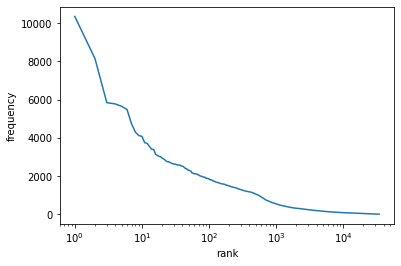

In [ ]:
plt.plot(np.arange(1,len(frequency_of_songs)+1),sorted_frequencies[0:len(frequency_of_songs)])
plt.ylabel('frequency')
plt.xlabel('rank')
plt.xscale('log')

plt.show()

In [ ]:
print(np.sum(sorted_frequencies[0:len(frequency_of_songs)]))
print(sorted_frequencies[0])

3457626
10361


## Networkx graph

### Utility Functions

In [ ]:
def create_networkx_graph(dataframe,source_col,target_col,source_node,target_node,create_using = nx.Graph,prune_nodes=False):
  G = nx.from_pandas_edgelist(dataframe, source=source_col, target=target_col,create_using=create_using)
  if prune_nodes==True:
    print("Pruning nodes")
    to_remove = []
    indeg = G.in_degree()
    for (node, degree) in notebook.tqdm(indeg):
      if node.startswith(target_node) and degree<2:
        to_remove.append(node)
    G.remove_nodes_from(to_remove)

    to_remove = []
    outdeg = G.out_degree()
    for (node, degree) in notebook.tqdm(outdeg):
      if node.startswith(source_node) and degree<2:
        to_remove.append(node)
    G.remove_nodes_from(to_remove)


  return G

In [ ]:
def create_color_map(G,nodes_list,colors_list):
  color_map = []
  for node in notebook.tqdm(G):
    for i in range(len(nodes_list)):
      if node.startswith(nodes_list[i]):
          color_map.append(colors_list[i])
  return color_map

In [ ]:
def find_degree(G, node_name):
  degree_dict = {}
  for node in notebook.tqdm(G.nodes):
    if node.startswith(node_name):
      degree_dict[node] = len(list(G.predecessors(node))) + len(list(G.successors(node)))
  degree_series = pd.Series(degree_dict, name='connections')
  degree_df = degree_series.to_frame().sort_values('connections',ascending=False).reset_index()
  return degree_df

In [ ]:
def plot_nx_grph(G,color_map, node_size=1200, linewidths=0.25,
    font_size=10, font_weight='bold', with_labels=True,x_size=100,y_size=100):
  plt.figure(figsize=(x_size,y_size))  
  nx.draw(G, node_color=color_map, node_size=node_size, linewidths=linewidths,
    font_size=font_size, font_weight=font_weight, with_labels=with_labels)
  plt.show()

### Music Session Graph

In [ ]:
s = songs.groupby(['session_id']).filter(lambda x: len(x) >= 10)
s['session_id'] = 'session' + s['session_id'].astype(str)

In [ ]:
print(s.head())

            user_id                               artist_id  \
815     user5181041  artist52a52d59c20c318e3ea76caea943b57b   
4838    user5181041  artist2e7b47e992f6f58541c44a19b0c10442   
7192  user255810748  artist23a2193a36b72b1eba98b0bee269edde   
7662  user609254455  artistb31cc180eb21f511abd6f2295cb99a27   
7664  user609254455  artist38c73e5c1209a1594ae37ff402518d73   

                                   track_id          created_at  \
815   trackff656aa42dbdfcb35155d340cb7750c9 2014-07-05 06:07:36   
4838  track7201d7ffd5b01a3f6da1e344b2c21a0c 2014-08-15 16:54:13   
7192  track5758909ef03fc3a2efaa57408ad43f22 2014-07-13 13:33:20   
7662  track8ee14256e2012c226e99b7533c260530 2014-01-06 08:00:03   
7664  track7fa57d45c61f3ff4d446f99a00f87d8b 2014-01-06 08:22:59   

      sentiment_score    lang            session_id  
815               0.9  langja  sessionsession707521  
4838              0.3  langja  sessionsession707541  
7192              1.1  langja  sessionsession434346  
76

In [ ]:
music_sessionG = create_networkx_graph(dataframe=s,source_col='track_id',target_col='session_id',source_node='track',target_node='session',create_using=nx.MultiDiGraph ,prune_nodes=False)

In [ ]:
color_map = create_color_map(G=music_sessionG,nodes_list=['track','session'],colors_list=['red','yellow'])

  0%|          | 0/67493 [00:00<?, ?it/s]

In [ ]:
print("Session Nodes")
print(find_degree(G=music_sessionG,node_name='session').tail())
print(find_degree(G=music_sessionG,node_name='session').shape)
print("Track nodes")
print(find_degree(G=music_sessionG,node_name='track').tail())
print(find_degree(G=music_sessionG,node_name='track').shape)

TOP_SESSION = str(find_degree(G=music_sessionG,node_name='session').head(1).iloc[0][0])
print(TOP_SESSION)

Session Nodes


NameError: ignored

### Sessions

In [ ]:
#Remove session with less than 10 tracks and combine into lists
sessions = songs.groupby(['session_id']).filter(lambda x: len(x) >= 5)

# sessions = sessions[['user_id','session']]
sessions = sessions.groupby(['session_id']).agg({'track_id':lambda x: list(x),'artist_id':lambda x: list(x),'created_at':lambda x: list(x),'user_id':lambda x: list(x)})
# sessions = sessions.groupby(['session']).agg({'artist_id':lambda x: list(x)})
sessions.reset_index(inplace=True)
sessions['user_id'] = sessions['user_id'].apply(lambda x: x[0])

print(sessions.head())
print(sessions.shape)

     session_id                                           track_id  \
0  session10000  [trackee97cea7e06f7cf5b82b566aa801fe86, trackc...   
1  session10003  [track5072e39bb12c31c543d09a20dd25a715, track8...   
2  session10004  [trackc23b245c8f60ef8682f62e5c77659fd9, track5...   
3  session10007  [trackb481ef30df3e6a943e969c4a8b001739, trackb...   
4  session10009  [trackfd072306fb45d4ed2d0bc964d0d9c72d, track1...   

                                           artist_id  \
0  [artistde88b1d1abf69a8537aed23f7f62a8f0, artis...   
1  [artistaf18c8a645562bb82d97d912faf14a54, artis...   
2  [artist1ba1ebf397160be29bfabf74903d7814, artis...   
3  [artistd994dbeba9fef0bc8af6d9dbd45665a8, artis...   
4  [artistd8c1ea5e041e32c836dac38d7f5b32a3, artis...   

                                          created_at        user_id  
0  [2014-04-17 04:07:17, 2014-04-17 04:11:57, 201...  user103395223  
1  [2014-04-17 07:04:46, 2014-04-17 07:15:16, 201...  user103395223  
2  [2014-04-17 08:02:19, 2014-04

In [ ]:
def create_graph(dataframe=sessions):
  G = nx.DiGraph()
  for index, row in dataframe.iterrows():
    # current_G = nx.DiGraph()
    tracks_list = row['track_id']
    artist_list = row['artist_id']
    G.add_nodes_from(tracks_list)
    G.add_nodes_from(artist_list)
    G.add_node(row['session_id'])
    G.add_node(row['user_id'])
    for i in range(len(tracks_list)-1):
      nx.add_path(G, (tracks_list[i],tracks_list[i+1])) 
      nx.add_path(G, (tracks_list[i],artist_list[i])) 
      nx.add_path(G, (row['user_id'],tracks_list[i])) 
      nx.add_path(G,(tracks_list[i],row['session_id']))
    nx.add_path(G, (tracks_list[len(tracks_list)-1],artist_list[len(tracks_list)-1])) 
    nx.add_path(G, (row['user_id'],tracks_list[len(tracks_list)-1])) 
    nx.add_path(G,(tracks_list[len(tracks_list)-1],row['session_id']))
  # G = nx.compose(G,current_G)
  return G

  

In [ ]:
music_session_graph = create_graph(sessions)

In [ ]:
color_map = create_color_map(G=music_session_graph,nodes_list=['user','track','artist','session','lang'],colors_list=['blue','red','green','yellow','black'])

  0%|          | 0/282486 [00:00<?, ?it/s]

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
# plot_nx_grph(music_session_graph,color_map,node_size=2500,font_size=25,x_size=50,y_size=50)
plot_nx_grph(music_session_graph,color_map)


KeyboardInterrupt: ignored

In [ ]:
with open('large_graph.pickle', 'wb') as f:
    pickle.dump(music_session_graph, f)

## word2vec

### Using listening sequence

#### Convert dataframe to iterable because word2vec expects a restartable iterable

In [ ]:
def session_format(sessions):
    documents = []
    for index, row in sessions.iterrows():
        preprocessed_songs = row['track_id']
        documents.append(preprocessed_songs)

    return documents    

In [ ]:
session_formatted = session_format(sessions)
session_length = len(session_formatted)
print(session_length)

244542


#### Training Word2vec-music recommender

In [ ]:
np.random.seed(42)

In [ ]:
#Train with 80 % of the data (with cross validation) and test the final model with 20% of the data
#train/test split for spotify session
index = np.random.choice(range(session_length), session_length, replace=False)
train = np.array(session_formatted)[index[:int(session_length * 0.8)]].tolist()
test = np.array(session_formatted)[index[int(session_length * 0.8):]].tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [ ]:
print(train[0])

['track1732f050f9bf38fa4dfe1cca53ef0356', 'trackbaae326ddce5f8e37324f22f6b97b4d7', 'trackbaae326ddce5f8e37324f22f6b97b4d7', 'trackacca7456f99b4699871d3fe249e5fe11', 'trackfc0bdea3f553c81054f8f194f79b7b04']


#### Evaluation

In [ ]:
def test_HR_and_NDGC_single_item(session, index, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    query = session[index]
    word = session[index + 1]
    try:
        res = model.wv.most_similar(positive=query, topn=k)
        for i in range(k):
            if res[i][0] == word:
                hits += 1
                ndgc += 1 / (math.log2(i + 1))
        tries += 1
    except:
        fails += 1 
    return (hits, ndgc, tries, fails)


def test_HR_and_NDGC_whole_test_set(test_set, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    for session in test_set:
        for ind in range(len(session) - 1):
            hi, nd, tr, fa = test_HR_and_NDGC_single_item(session, ind, k)
            hits += hi
            ndgc += nd
            tries += tr
            fails += fa
    return (hits, ndgc, tries, fails)


def test_HR_and_NDGC_one_task_per_session(test_set, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    for session in test_set:
        ind = random.randrange(len(session) - 1)
        hi, nd, tr, fa = test_HR_and_NDGC_single_item(session, ind, k)
        hits += hi
        ndgc += nd
        tries += tr
        fails += fa
    return (hits, ndgc, tries, fails)


In [ ]:
def grid_search(*iterables):
    # create all combinations of input values
    return np.array(np.meshgrid(*iterables)).T.reshape(-1, len(iterables))


workers = 12
k = 10  # predicted items
sg = 0  # 0 for cbow 1 for skipgram

window_options = [3,5,7,9,11,13]  # window size L
# it_options = [5, 25, 100]  # epochs n
# it_options = [5,15]  # epochs n
# sample_options = [0.00006,0.000075,]  # sub-sampling t
negative_sampling_dist = [0.75,1.1,1.25]  # negative sampling distribution parameter a

# size_embedding_options = [40,80,120]  # embedding size
# neg_options = [15,25]  # negative samples amount
# alpha = [0.001,0.025,0.005]  # learning rate
# min_count_options = [5,10]  # words under this are ignored

hyperparameters = []
hit_ratios = []
NDCG = []
best_model = None


for (
    n_window,
    # n_it,
    # n_sample,
    n_neg_sample_dist,
    # n_size,
    # n_neg,
    # n_alpha,
    # n_min_count,
) in notebook.tqdm(grid_search(
    window_options,
    # it_options,
    # sample_options,
    negative_sampling_dist,
    # size_embedding_options,
    # neg_options,
    # alpha,
    # min_count_options,
)):
    hyperparameters.append(
        [
            n_window,
            # n_it,
            # n_sample,
            n_neg_sample_dist,
            # n_size,
            # n_neg,
            # n_alpha,
            # n_min_count,
        ]
    )
    model = gensim.models.Word2Vec(
        train,
        # vector_size=int(n_size),
        window=int(n_window),
        # min_count=int(n_min_count),
        workers=workers,
        sg=sg,
        # epochs=int(n_it),
        # sample=n_sample,
        # negative=int(n_neg),
        ns_exponent=n_neg_sample_dist,
        # alpha=n_alpha,
    )

    model.train(train, total_examples=len(train), epochs=model.epochs)
    hits, ndgc, tries, fails = test_HR_and_NDGC_whole_test_set(test, k)
    if tries == 0:
        hit_ratio=1
    else:
        hit_ratio = hits / tries
    if hit_ratios and hit_ratio > max(hit_ratios):
        best_model = model
    hit_ratios.append(hit_ratio)
    if tries==0:
        NDCG.append(1)
    else:    
        NDCG.append(ndgc / tries)


  0%|          | 0/18 [00:00<?, ?it/s]

#### Choosing the best combination

In [ ]:
# print the combinations and their accuracy.
acc_and_hyper = list(
    map(list, zip(hit_ratios, NDCG, hyperparameters))
)  # [list(i) for i in zip(accuracies, hyperparameters)]
acc_and_hyper = list(map(lambda x: [x[0], x[1]] + x[2], acc_and_hyper))
acc_and_hyper.sort(key=lambda x: x[0],reverse=True)
acc_and_hyper = pd.DataFrame(acc_and_hyper)
acc_and_hyper.columns = [
    "hit-ratio",
    "ndcq",
    "window-size",
    # "epochs",
    # "sub-sample",
    "negative-sampling-dist",
    # "embedding-size",
    # "negative-samples-size",
    # "learning-rate",
    # "mininum-count",
]


In [ ]:
#nowplaying sessions skipgram
print(acc_and_hyper.head())

   hit-ratio      ndcq  window-size  negative-sampling-dist
0   0.115314  0.048287          5.0                    1.25
1   0.115303  0.049369          5.0                    1.10
2   0.113777  0.048005          5.0                    0.75
3   0.113441  0.049797          7.0                    1.10
4   0.111875  0.046066          7.0                    0.75


#### Example recommendations

In [ ]:
print(model.wv.vectors)

[[ 1.7418547  -4.4688926   1.1046449  ... -0.23282567  1.0301491
  -4.0839133 ]
 [ 0.524034   -0.78515047  1.5457085  ... -1.1555535   1.0998552
   0.10800348]
 [-1.8438472   0.6808923   1.2146133  ... -0.06627005 -0.10142206
   0.81186646]
 ...
 [-0.04764442 -0.32019728  0.07454767 ... -0.21137325  0.21472484
   0.3291011 ]
 [-0.07232131 -0.3475982   0.08381969 ... -0.22514932  0.19814783
   0.36421525]
 [-0.03313494 -0.30550155  0.05835592 ... -0.1762122   0.20979343
   0.3286883 ]]


In [ ]:
for word in model.wv.vectors:
  print(word)

Streaming output truncated to the last 5000 lines.
 -0.08060713 -0.23634833 -1.7465284   1.6747211   0.99269223 -0.13806567
  0.65017396  1.3371575   0.2922115   0.43860072  0.8160714  -0.41001758
 -0.7323877  -0.74129695  0.51582456  0.5531105   0.01125204 -0.4002099
  0.7257742   0.38795212  0.36968178 -0.6443238  -1.0238042   0.86207944
 -0.17787884 -0.79299164  0.01963888  0.4526276  -0.36452827 -0.06933574
  0.5809311  -0.07559747 -0.15164447  0.7264208  -0.26387298  0.00343087
 -0.57585424 -0.33812144  0.75024855  0.95992845  0.9198084   0.7533951
 -1.6857704   0.02023239 -1.3973842   0.27235767  0.39761788 -0.24160966
 -0.74387753  0.68595773 -2.0662308   1.281915    1.0993555  -0.35962114
  0.9775699   0.43042412  0.6423478  -1.1425854  -1.6300819  -0.7921118
  0.949288   -0.5858712   0.51275784  1.1759048 ]
[-0.8835788  -0.69522494  1.7642833  -1.2739844  -0.2386017   1.2674613
 -0.4684275   0.6954621  -0.94590706 -0.926735   -0.7616685  -0.16463853
  0.2878713  -0.23822527  0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  0.71112424 -0.6865865   0.35087743  0.69818735]
[ 0.43247086 -0.9263637  -0.18433125 -0.88259846  0.11244148 -1.007419
 -0.11788417 -1.22307     0.05856461  0.09960261  0.4963041  -0.31132928
  0.15701802  0.15305537  0.11480916  0.21659164  0.17413816 -0.7680224
  0.06436725 -1.0662332  -0.10784666  0.13938193  0.6866726   0.0476676
 -0.30396196  0.22983052 -0.21917166  0.79057664  0.7384078   0.40092874
 -0.7532364   0.3608453  -1.2232293   0.55671823  0.8101348  -0.4260743
 -1.076319    0.49681368 -1.1477782   1.3266703  -1.2036458  -0.12571618
 -0.07273993  0.24904929  0.07463692  0.10601629  0.6238042  -0.75100285
 -0.03462702 -0.38044965 -0.6414145  -0.22189607 -0.16672945  0.11674348
 -0.38360918 -0.0475721  -0.12315219  0.19742757  0.72177875 -0.28199407
  0.20233725  0.42557803  0.22032331  0.6467509   0.14860785  0.4785084
 -0.15507306  0.59766716 -0.45781547  0.73130584  0.3080935   0.14680511
 -0.8288931   0.23509218 -0.2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 -1.08690169e-02  4.48280305e-01  2.92513520e-02  1.11043185e-01
 -3.35465461e-01  5.82934737e-01 -5.02143102e-03  1.02008902e-01
  2.99808800e-01  7.27671981e-02 -1.66050401e-02  1.88933924e-01
  2.09154226e-02 -1.11537255e-01 -2.91630417e-01 -5.38160503e-02
  2.67866284e-01 -7.10915849e-02  6.36828423e-01  2.61752069e-01
 -1.53504670e-01 -9.21954989e-01  1.13967136e-01  2.37925321e-01
  7.99675882e-01 -4.90563773e-02 -2.21989930e-01 -3.27615105e-02
 -3.99469614e-01  4.41234380e-01 -9.43769515e-02  3.47508788e-02
 -7.05809146e-02 -2.62754649e-01 -2.19970662e-03 -2.19792295e-02
  4.47908230e-02 -5.11842728e-01  1.81974038e-01 -3.30343395e-02]
[-0.1399811  -0.77647907 -0.27531973 -0.9272843  -0.30327746 -0.07150089
  0.1915368  -0.53810585 -0.22978735 -0.57849944 -0.39283264  0.72134835
  0.03235233  0.08306161  0.6255474  -0.19802892 -0.26077613 -0.42753652
 -0.2903683  -0.23810647 -0.44409394 -0.09705108  0.20548892 -0.15510578
  0.28

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  0.08082617 -0.1161354   0.01999518 -0.09505325 -0.20719051 -0.09281938
 -0.03215812  0.11019085 -0.05548094 -0.06714484 -0.28112432 -0.08639328
  0.09087352 -0.02849284 -0.02732688 -0.11939437  0.03702067 -0.19153994
  0.02008083  0.12810263 -0.05859055  0.0024869   0.06681854  0.10093517
 -0.00810415 -0.03833452 -0.0766127   0.09570553  0.42657343  0.11310212
  0.06524934 -0.10460495  0.03457375  0.14332663  0.22512464  0.0520731
  0.14919034 -0.07193283  0.1152662   0.05983626 -0.15846637 -0.19899249
 -0.16978864 -0.11849438  0.06258282 -0.06023796 -0.21421373  0.01384227
  0.26875564 -0.06738243  0.20926173 -0.02605346 -0.35573986  0.05308289
 -0.0498153  -0.0775163  -0.20319456  0.13314751 -0.1946372   0.10087137
 -0.08818701  0.10106713  0.01657807  0.2996682  -0.06234558 -0.01372045
  0.12656341 -0.20984185  0.20428476 -0.14832766 -0.01193196  0.06802575
 -0.2223243  -0.050977   -0.3815588   0.10022622  0.08283786  0.07405967
 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  0.07017031 -0.33361045 -0.22019617  0.00252961 -0.14293097  0.03362559
  0.01152196  0.11634892  0.11419658  0.10092933  0.06065118 -0.05682492
 -0.07588025 -0.06538133 -0.19506565  0.13504462 -0.0311434  -0.07705569
 -0.10791902  0.02615951 -0.22489528 -0.14765017 -0.0451787  -0.0102378
 -0.18473807  0.07160784 -0.08965291  0.21021664 -0.01746002  0.06210438
  0.05921388 -0.16019793  0.11644867 -0.09654651 -0.33081505  0.01896881
  0.16235968  0.11119395  0.12018022  0.18973085]
[-0.23242117 -0.20049004  0.21952225 -0.13507672 -0.23542766 -0.11893164
 -0.23928347 -0.13419412 -0.33376342  0.13762848  0.03286125 -0.20774409
 -0.23086312 -0.22720367  0.26773453 -0.09181978 -0.16554281 -0.3272852
  0.04660141  0.18154626 -0.15492828  0.00203858  0.19057177 -0.06758505
 -0.07692126  0.0444902   0.1411874   0.20940496  0.13491188  0.04360085
 -0.04964122  0.05020535 -0.26087412  0.2290801   0.48337054  0.01308141
 -0.30973274 -0.17915735 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 -8.43862966e-02 -2.49432564e-01 -1.19818166e-01  2.27289483e-01
  5.59425093e-02  7.85076469e-02 -4.78387587e-02  7.67768770e-02
 -1.79716587e-01  1.99034110e-01 -3.36820036e-02  2.14599967e-02
  3.54061536e-02  2.41593629e-01 -8.55847970e-02  5.44600002e-02
 -1.61609843e-01 -1.57745942e-01 -4.43513244e-02  3.10863703e-02
  1.47787437e-01  6.60452573e-03 -3.08118071e-02  4.56755161e-02
 -2.67778426e-01 -3.06262374e-01  6.35509789e-02  1.33374691e-01
  2.65298873e-01  1.61491171e-01 -4.39517170e-01  1.25248685e-01
  6.34875298e-02  9.37955678e-02  1.16016455e-01 -3.30896862e-02
  1.18501045e-01 -3.41753483e-01 -2.70355433e-01 -2.73070186e-01
  1.26725629e-01 -2.03738615e-01  2.69664168e-01  3.61182183e-01]
[-0.11635733 -0.07998756  0.15955558 -0.08810815 -0.0974815  -0.02521801
 -0.09237631  0.0374994  -0.23171206  0.0168457   0.01010037 -0.15864986
 -0.05462287 -0.077365    0.21189421 -0.11412722 -0.03447189 -0.22485429
 -0.02683105  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  0.02643653 -0.01845851  0.00885323  0.09088765 -0.01372147 -0.08278698
  0.05374581  0.00838829  0.08879004 -0.04140824 -0.05833822  0.0751407
 -0.11252882 -0.1142297  -0.16377474  0.13225436  0.03599313 -0.00343392
  0.00021966 -0.00150258 -0.03663021  0.11983856  0.12842655 -0.03843488
  0.09568369 -0.06069767  0.04009454 -0.08096281 -0.06977066 -0.05036698
 -0.00032034  0.06349956  0.04551977  0.06058975]
[-0.07589979 -0.02007795  0.14773476 -0.09327231  0.05597859  0.12693958
 -0.00775421  0.03148652 -0.0458248  -0.02860782 -0.01935012 -0.04375956
  0.02488311 -0.04931186  0.08181237 -0.05230687  0.01630631 -0.10094393
 -0.10341739  0.00776425 -0.0557039   0.07232084  0.15279606 -0.05476191
 -0.03313735  0.03815359  0.05754692  0.0130788  -0.05471839  0.07861111
 -0.09702317  0.01968999  0.02991251  0.15933493  0.14019528 -0.03796767
 -0.06717913 -0.06701203  0.01000185  0.08822922 -0.03263362  0.04270117
  0.05245373  0.07645872

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  1.00856178e-01  6.24916330e-02  9.13803745e-03  5.38386703e-02
 -3.37852687e-02  6.79140585e-03 -1.40863836e-01  2.21480634e-02
  4.43789400e-02 -1.59937546e-01 -6.53880369e-03  1.11164153e-01
  1.60331484e-02 -1.68651998e-01 -7.97303841e-02  1.34419620e-01
  2.71431450e-03  5.06690517e-02 -3.05113718e-02  1.47478106e-02
 -8.85406360e-02  7.80549049e-02 -1.38464826e-03  6.13144673e-02
 -1.75831113e-02  4.65717353e-02 -7.64924884e-02  5.39521165e-02
 -1.45431012e-01 -8.71932581e-02 -8.47962499e-02  9.66168847e-03
  7.12650791e-02  1.51805179e-02  2.71014869e-02  4.67721978e-03
 -5.85840531e-02 -1.35457382e-01 -8.15375336e-03  5.59756793e-02
  1.15964264e-01  1.01720653e-01 -1.88184828e-01 -2.85487268e-02
 -2.18903366e-02 -1.69137120e-02  8.10085386e-02  1.94191933e-04
 -1.94218401e-02 -1.22573964e-01 -1.41709626e-01 -9.31546092e-02
  5.71861267e-02 -1.06680803e-01  1.00769401e-01  2.50474155e-01]
[-0.05750336 -0.21055028  0.0918196  -

In [ ]:
w1 = "track3c45a30a72620d2f62545807cd7b6de1"
model.wv.most_similar(positive=w1.lower(), topn=20)

[('trackcd5eaf4d19a30e5aee34a692ebd6b9b8', 0.9057616591453552),
 ('track0b0abec555f72c87bb37011e8c98ef6d', 0.8996720314025879),
 ('trackb84dbfa1ec0a55fe85d49ac1bf416690', 0.8895532488822937),
 ('track87adbae29e0abae787e1d1df2950a5e5', 0.8866129517555237),
 ('track5bf114679a6cc4846b8ddab5b3f45116', 0.8820918798446655),
 ('track50c8e1e63354add5ad62e7a017a93639', 0.8787204027175903),
 ('track4f6aa02fde7fa9e02664d2da8caea0a4', 0.8785692453384399),
 ('track03f18c66b6d9807571aeca25cf384afc', 0.8711695075035095),
 ('track6b93196f55860f7f8125e72bd657b1db', 0.8662109375),
 ('track79a9eb05aff1dbfe8ff033d3a5271359', 0.8657876253128052),
 ('trackde9936c17157ea6e76d8ddd3a66d74e4', 0.8657318949699402),
 ('tracke78590f08f02e22779e3b3fe5c9eb419', 0.8652783632278442),
 ('track2dfff45586b32499258483feb1c56a55', 0.8651034235954285),
 ('track38a325fb71115d6053e557fa3b34d843', 0.8644965291023254),
 ('trackc74a16e31f6d14602ca346602560bca8', 0.863515317440033),
 ('trackc68796e70cbd802582f4155b9e35fc04', 0.86

In [ ]:
def compare_similarity(song1, song2):
    similarity_score = model.wv.similarity(song1.lower(), song2.lower())
    return similarity_score
    

### Visualizing embedding

In [ ]:
vocab = list(model.wv.index2word)
X = model.wv[vocab]
X.shape

(21546, 100)

In [ ]:
index = np.random.choice(range(len(X)), 100,replace=False)
subset_x = np.array(X)[index]
labels = np.array(vocab)[index]

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(subset_x)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


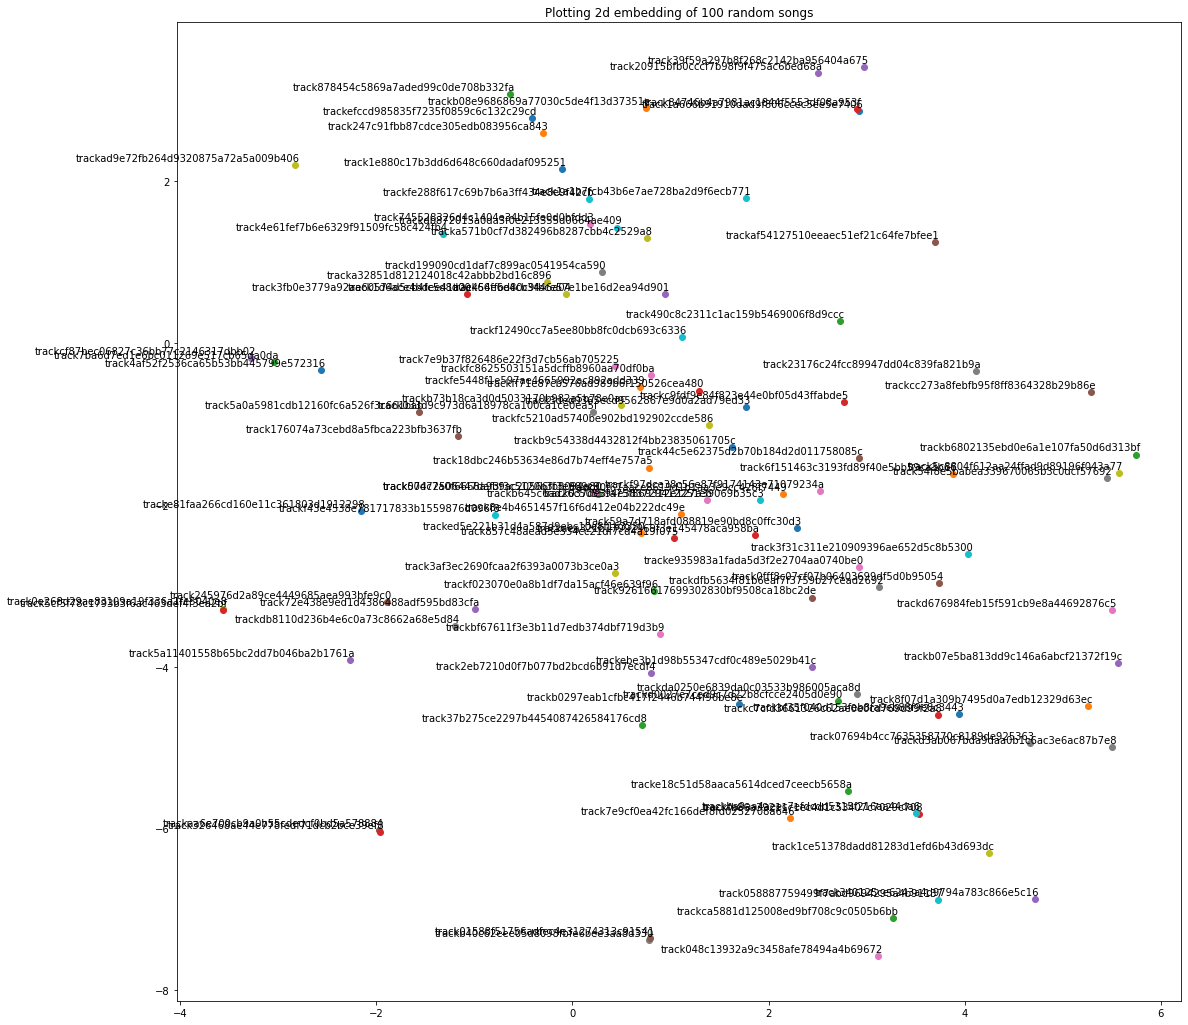

In [ ]:
def label_format(label, condition=0):
    if condition == 1:
        return label.split("-", 1)[0]
    elif condition == 2:
        return label.split("-", 1)[1]
    else:
        return label


plt.figure(figsize=(18, 18))
plt.title("Plotting 2d embedding of 100 random songs")
for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i, 0], X_tsne[i, 1])
    plt.annotate(
        label_format(labels[i], 0),
        xy=(X_tsne[i, 0], X_tsne[i, 1]),
        xytext=(5, 2),
        textcoords="offset points",
        ha="right",
        va="bottom",
    )
plt.show()


In [ ]:
#nep on train 
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_session(train, k)
print((hits/tries, ndgc/tries, tries, fails))

(0.2627885297825235, 0.07147873347813613, 188802, 6831)


In [ ]:
#nep on test
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_session(test, k)
print((hits/tries, ndgc/tries, tries, fails))

(0.2602920515986206, 0.07032927767887642, 46978, 1931)


### Using Random Walk

In [ ]:
def random_walk(graph, node, n_steps = 5):
    ''' Function that takes a random walk along a graph'''
    local_path = [str(node),]
    target_node = node
    
    # Take n_steps random walk away from the node (can return to the node)
    for _ in range(n_steps):
        neighbours = list(nx.all_neighbors(graph, target_node))
        try:
            target_node = random.choice(neighbours)
        except Exception as e:
            print(f'error with node {node}')
            print(str(e))
        local_path.append(str(target_node))
        
    return local_path

In [ ]:
import pickle
with open("/content/drive/MyDrive/large_graph.pickle", "rb") as f:
    music_session_graph = pickle.load(f)

In [ ]:
walk_paths_weighted = []

i = 0
for node in notebook.tqdm(music_session_graph.nodes()):
    for _ in range(10):
        walk_paths_weighted.append(random_walk(music_session_graph, node))

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
from itertools import chain
walk_paths_length = len(walk_paths_weighted)
#Train with 80 % of the data (with cross validation) and test the final model with 20% of the data
#train/test split for spotify session
index = np.random.choice(range(walk_paths_length), walk_paths_length, replace=False)
train = np.array(walk_paths_weighted)[index[:int(walk_paths_length * 0.8)]].tolist()
train = list(chain.from_iterable(train))
test = np.array(walk_paths_weighted)[index[int(walk_paths_length * 0.8):]].tolist()
test = list(chain.from_iterable(test))

In [ ]:
# Instantiate the embedder
embedder_weighted = Word2Vec(window = 4, sg=1, negative=10, alpha=0.03, min_alpha=0.0001, seed=42)
# Build the vocab
embedder_weighted.build_vocab(train, progress_per=2)
# Train teh embedder to build the word embeddings- this takes a little bit of time
embedder_weighted.train(train, total_examples=embedder_weighted.corpus_count, epochs=40, report_delay=1)

(3959185, 23856520)

#### Prediction

In [ ]:
for word in embedder_weighted.wv.index2word:
  print(word)

a
c
5
e
2
9
1
8
4
6
7
3
0
f
b
d
r
t
k
s
u
i


In [ ]:
x_ = embedder_weighted.wv.most_similar('trackb2a0f433e68fb88575ba1e43a14662dc', topn=100)
print("Closest nodes for user823876015")
[i[0] for i in x_]

KeyError: ignored

In [ ]:
recommended_songs =[]
for node in x_:
  if node[0].startswith('track'):
    recommended_songs.append(node[0])
print(recommended_songs)

['track327335470f6a286d355462841f9ece52', 'track85fce28234ac2d3b19772dec2b1e82d3', 'trackb505d83d98ad0f0db6aaa282295320bf', 'track4299ad41aaba3d7187bced53f6c8df16', 'track39f59a297b8f268c2142ba956404a675', 'track73cc57f2e6c7c31fe5559f582ae48f78', 'track1da9bd22cc688806a394d09e61efb9bb', 'tracka8c09cefc71c6d067f1491b630cadf1d', 'track3bf858f6ec39d7bef05d02fc74f1275f', 'trackc6dc6dad68152641ea724404775fa1d9', 'track219347b02b185b9bba3292003ec349fc', 'track6f43dd2b5881ab827a2e45800ea70a34', 'track3ded9365ecd9562867e9d0a2ad79ed33', 'track860204cb8b9e3f53d06fe935bcdc3945', 'trackc56712d7d3de480aedecf1fb087170b5', 'trackd53b2de022666067050dae8f6645edc2', 'trackc22c1b722058bb970b9ab2e1538c0ba8', 'trackd37a18886cf98db69222b47e825058cb', 'trackb04ed34e3b1e861b0ff0b574a797abda', 'track1333719ea1575e5307851bfaf8bf8178', 'track109c15b2ced84bc03578c1ad1b0ee0b4', 'track93c6775eab2f1aef4cfa68188701eb9f', 'track931cf64f1c7e17a5761eea577b750de1', 'track86b8e0b8abf006a40ac3aa12b460bbc4', 'track939288346

In [ ]:
with open('embedder_weighted.pickle', 'wb') as f:
    pickle.dump(embedder_weighted, f)


#### Evaluation

In [ ]:
#nep on train 
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_whole_test_set(train, k)
print((hits/tries, ndgc/tries, tries, fails))

(0.37564685879542575, 0.11494356372188118, 188797, 578814)


In [ ]:
#nep on test
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_whole_test_set(test, k)
print((hits/tries, ndgc/tries, tries, fails))

(0.30998129569801053, 0.0899931984356402, 47048, 47048)
